In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import tifffile as tf
import plotly.graph_objects as go
plt.style.use(r"C:\Users\dan20\OneDrive - Johann Wolfgang Goethe Universität\Module\Masterarbeit\daniels_custom_stylesheet.matplotlibrc")
#plt.rcParams['text.usetex'] = True
#plt.rcParams.update({'font.size': 20})

In [2]:
#load the precalculated PSFs
PSF_conventional = np.loadtxt(f'psf_conventional.csv', delimiter=',')
PSF_confocal = np.loadtxt(f'psf_confocal.csv', delimiter=',')
PSF_2p_conventional = np.loadtxt(f'psf_2p_conventional.csv', delimiter=',')
PSF_2p_confocal = np.loadtxt(f'psf_2p_confocal.csv', delimiter=',')
PSF_srs = np.loadtxt(f'psf_srs.csv', delimiter=',')


# Load the parameter dictionary
loaded_params = np.load("params.npz")

# Convert to regular Python dict
params = {k: loaded_params[k].item() if loaded_params[k].shape == () else loaded_params[k] for k in loaded_params}

#parameters in micrometers
wl_TPA = params["wl_TPA"]
wl_ill = params["wl_ill"]
wl_det = params["wl_det"]
wl_p = params["wl_p"]
wl_S = params["wl_S"]
num_ap = params["num_ap"]
ref_index = params["ref_index"]
M = params["M"]
pinhole_radius_airy = params["pinhole_radius_airy"]
pinhole_radius = params["pinhole_radius"]
ap_durch_f = params["ap_durch_f"]
r_min = params["r_min"]
r_max = params["r_max"]
r_num = params["r_num"]
z_min = params["z_min"]
z_max = params["z_max"]
z_num = params["z_num"]
print(params)
r_array=np.linspace(r_min,r_max,r_num)
z_array=np.linspace(z_min,z_max,z_num)
theta_num=360
theta_array = np.linspace(0,360,theta_num)

{'wl_TPA': 0.9, 'wl_ill': 0.488, 'wl_det': 0.52, 'wl_p': 0.934, 'wl_S': 1.031, 'num_ap': 0.85, 'ref_index': 1.33, 'M': 32, 'pinhole_radius_airy': 1, 'pinhole_radius': 0.3731764705882353, 'ap_durch_f': 0.8309407549436357, 'r_min': -2, 'r_max': 2, 'r_num': 1001, 'z_min': -3, 'z_max': 3, 'z_num': 1001}


In [3]:
print(r_array)

[-2.    -1.996 -1.992 ...  1.992  1.996  2.   ]


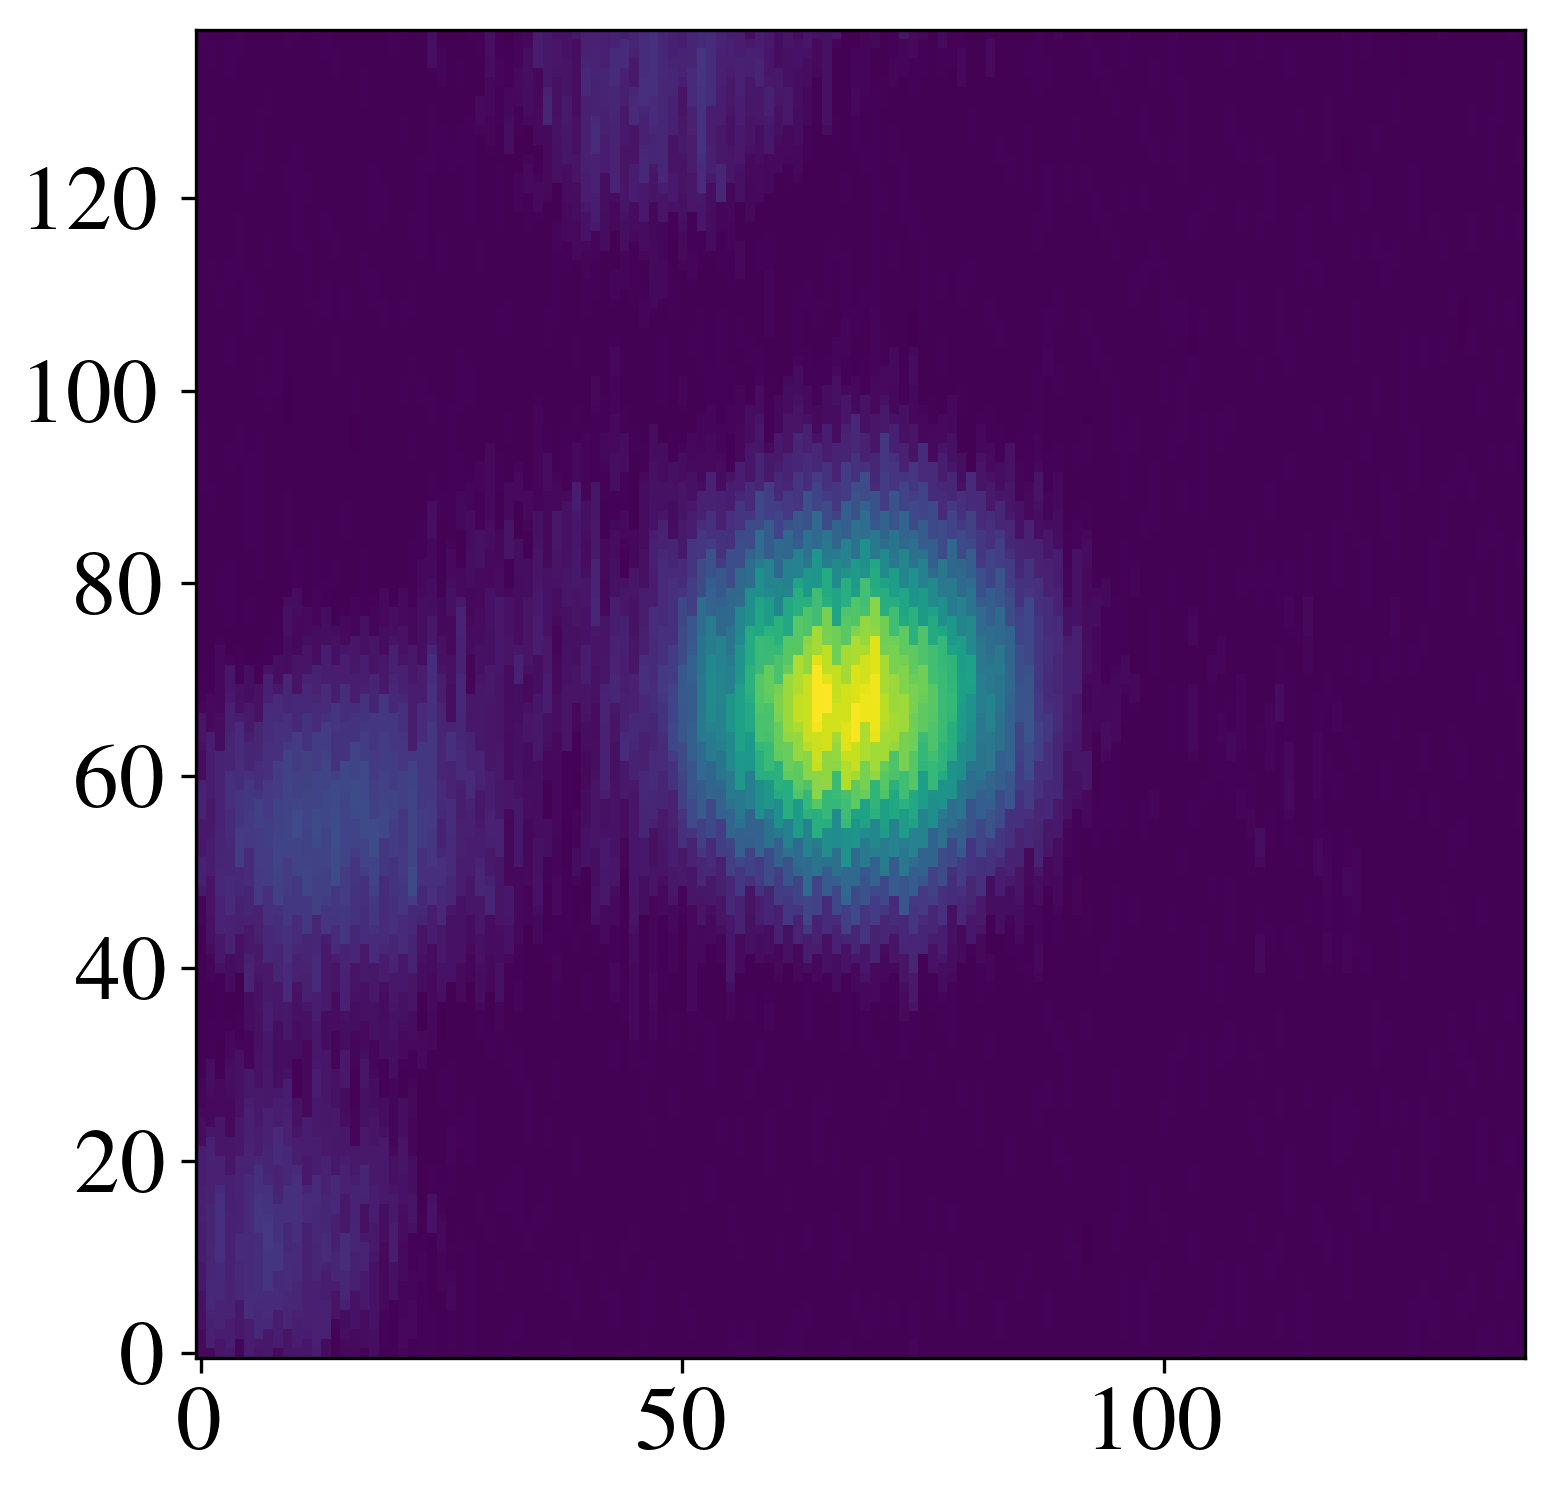

In [4]:
image=tf.imread(r"C:\Users\dan20\OneDrive - Johann Wolfgang Goethe Universität\Module\Masterarbeit\Aufnahmen\03-04\frame_1_cropped.tif")
image_cropped=np.copy(image.T-26)
image_cropped[np.unravel_index(np.argmax(image_cropped, axis=None), image_cropped.shape)]=0
image_1d=(image_cropped/np.max(image_cropped)).flatten()

plt.imshow(image_cropped,origin='lower')
plt.show()

In [5]:
#set image metadata
bead_diameter = 0.04 #in um
pixel_pitch = 0.0207566
y_resolution=len(image_cropped[:,0])
print(y_resolution)
x_resolution=len(image_cropped[0,:])
print(x_resolution)
x_array = np.arange(0,x_resolution,pixel_pitch)[:x_resolution]
print(x_array.shape)
y_array = np.arange(0,y_resolution,pixel_pitch)[:y_resolution]
X, Y = np.meshgrid(x_array,y_array)
data_points = np.vstack((np.ravel(X), np.ravel(Y))) #stack of 1d arrays in which each pair of x,y values occurs once

138
138
(138,)


In [6]:
#see https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function
def gaussian_2d(x,y,*p):#p=(mu_x, sigma_x, mu_y, sigma_y)
    a=np.cos(p[5])**2/(2*p[1]**2)+np.sin(p[5])**2/(2*p[3]**2)
    b=-1*np.sin(p[5])*np.cos(p[5])/(2*p[1]**2)+np.sin(p[5])*np.cos(p[5])/(2*p[3]**2)
    c=np.sin(p[5])**2/(2*p[1]**2)+np.cos(p[5])**2/(2*p[3]**2)
    return p[4]*np.exp(-1*a*(x-p[0])**2-1*b*(x-p[0])*(y-p[2])-1*c*(y-p[2])**2)
def gaussian_2d_vec(x,y,*p):
    a=np.cos(p[5])**2/(2*p[1]**2)+np.sin(p[5])**2/(2*p[3]**2)
    b=-1*np.sin(p[5])*np.cos(p[5])/(2*p[1]**2)+np.sin(p[5])*np.cos(p[5])/(2*p[3]**2)
    c=np.sin(p[5])**2/(2*p[1]**2)+np.cos(p[5])**2/(2*p[3]**2)
    return p[4]*np.exp(-1*a*(x[:,np.newaxis]-p[0])**2-1*b*(x[:,np.newaxis]-p[0])*(y[np.newaxis,:]-p[2])-1*c*(y[np.newaxis,:]-p[2])**2)
def model_func(data_points,*p):
    x = data_points[0]
    y = data_points[1]
    return gaussian_2d(x,y,*p)
def chi_squared(data_points, *p):
    #model_func_vec=np.vectorize(model_func,excluded='p')
    return np.sum((image_1d - model_func(data_points, *p))**2)

In [7]:
initial_guess = np.array([x_resolution/2*pixel_pitch,0.5,y_resolution/2*pixel_pitch,0.5,1,0]) #initial guess for the parameters
popt,pcov=sp.optimize.curve_fit(model_func,data_points,image_1d,p0=initial_guess)
reduced_chi_squared = chi_squared(data_points, *popt) / (len(image_1d) - len(popt))

In [8]:
print(f'Gaussian fit parameters: {popt}')
print(f'Gaussian fit covariance: {pcov}')
print(f'Reduced chi squared: {reduced_chi_squared}')

Gaussian fit parameters: [ 1.39861407  0.22416259  1.40629765  0.24699399  1.00285137 -3.11033944]
Gaussian fit covariance: [[ 4.21768730e-07 -1.97610575e-14  1.40934947e-09 -3.58808908e-17
   8.80988182e-14 -6.80193693e-14]
 [-1.97610575e-14  4.23725256e-07  1.78382003e-16 -2.73226055e-09
  -9.43279965e-07 -1.64394116e-06]
 [ 1.40934947e-09  1.78382003e-16  5.11842214e-07 -2.15584231e-14
   8.78663241e-14  5.87294772e-14]
 [-3.58808908e-17 -2.73226055e-09 -2.15584231e-14  5.15582100e-07
  -1.03933182e-06  2.19900932e-06]
 [ 8.80988182e-14 -9.43279965e-07  8.78663241e-14 -1.03933182e-06
   8.44006115e-06  1.88065595e-13]
 [-6.80193693e-14 -1.64394116e-06  5.87294772e-14  2.19900932e-06
   1.88065595e-13  1.77418219e-03]]
Reduced chi squared: 0.0017036878467164525


In [9]:
print(f'x-Position: {popt[0]} microns')
print(f'x std: {popt[1]} microns')
print(f'x FWHM: {2.355*popt[1]} microns')
print(f'y-Position: {popt[2]} microns')
print(f'y std: {popt[3]} microns')
print(f'x FWHM: {2.355*popt[3]} microns')
print(f'Intensity: {popt[4]} microns')
print(f'Rotation: {popt[5]} rad')
popt_zero=[0,popt[1],0,popt[3],1.0,0]#set positions to 0 for plotting

x-Position: 1.398614067480832 microns
x std: 0.22416259065235758 microns
x FWHM: 0.5279029009863021 microns
y-Position: 1.4062976457278311 microns
y std: 0.24699399398738345 microns
x FWHM: 0.581670855840288 microns
Intensity: 1.0028513721452326 microns
Rotation: -3.1103394429253304 rad


In [10]:
fitted_gaussian=gaussian_2d_vec(x_array,y_array,*popt)
print(fitted_gaussian.shape)

(138, 138)


C:\Users\dan20\AppData\Local\Temp\ipykernel_18744\209344448.py:32: UserWarning: The following kwargs were not used by contour: 'label', 'antialiasing'
  cf=ax.contourf(x_array,y_array,fitted_gaussian.T,vmax=popt[4], levels=contourf_levels, cmap=cmap, label='Least Squares Fit',antialiasing=True)
C:\Users\dan20\AppData\Local\Temp\ipykernel_18744\209344448.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


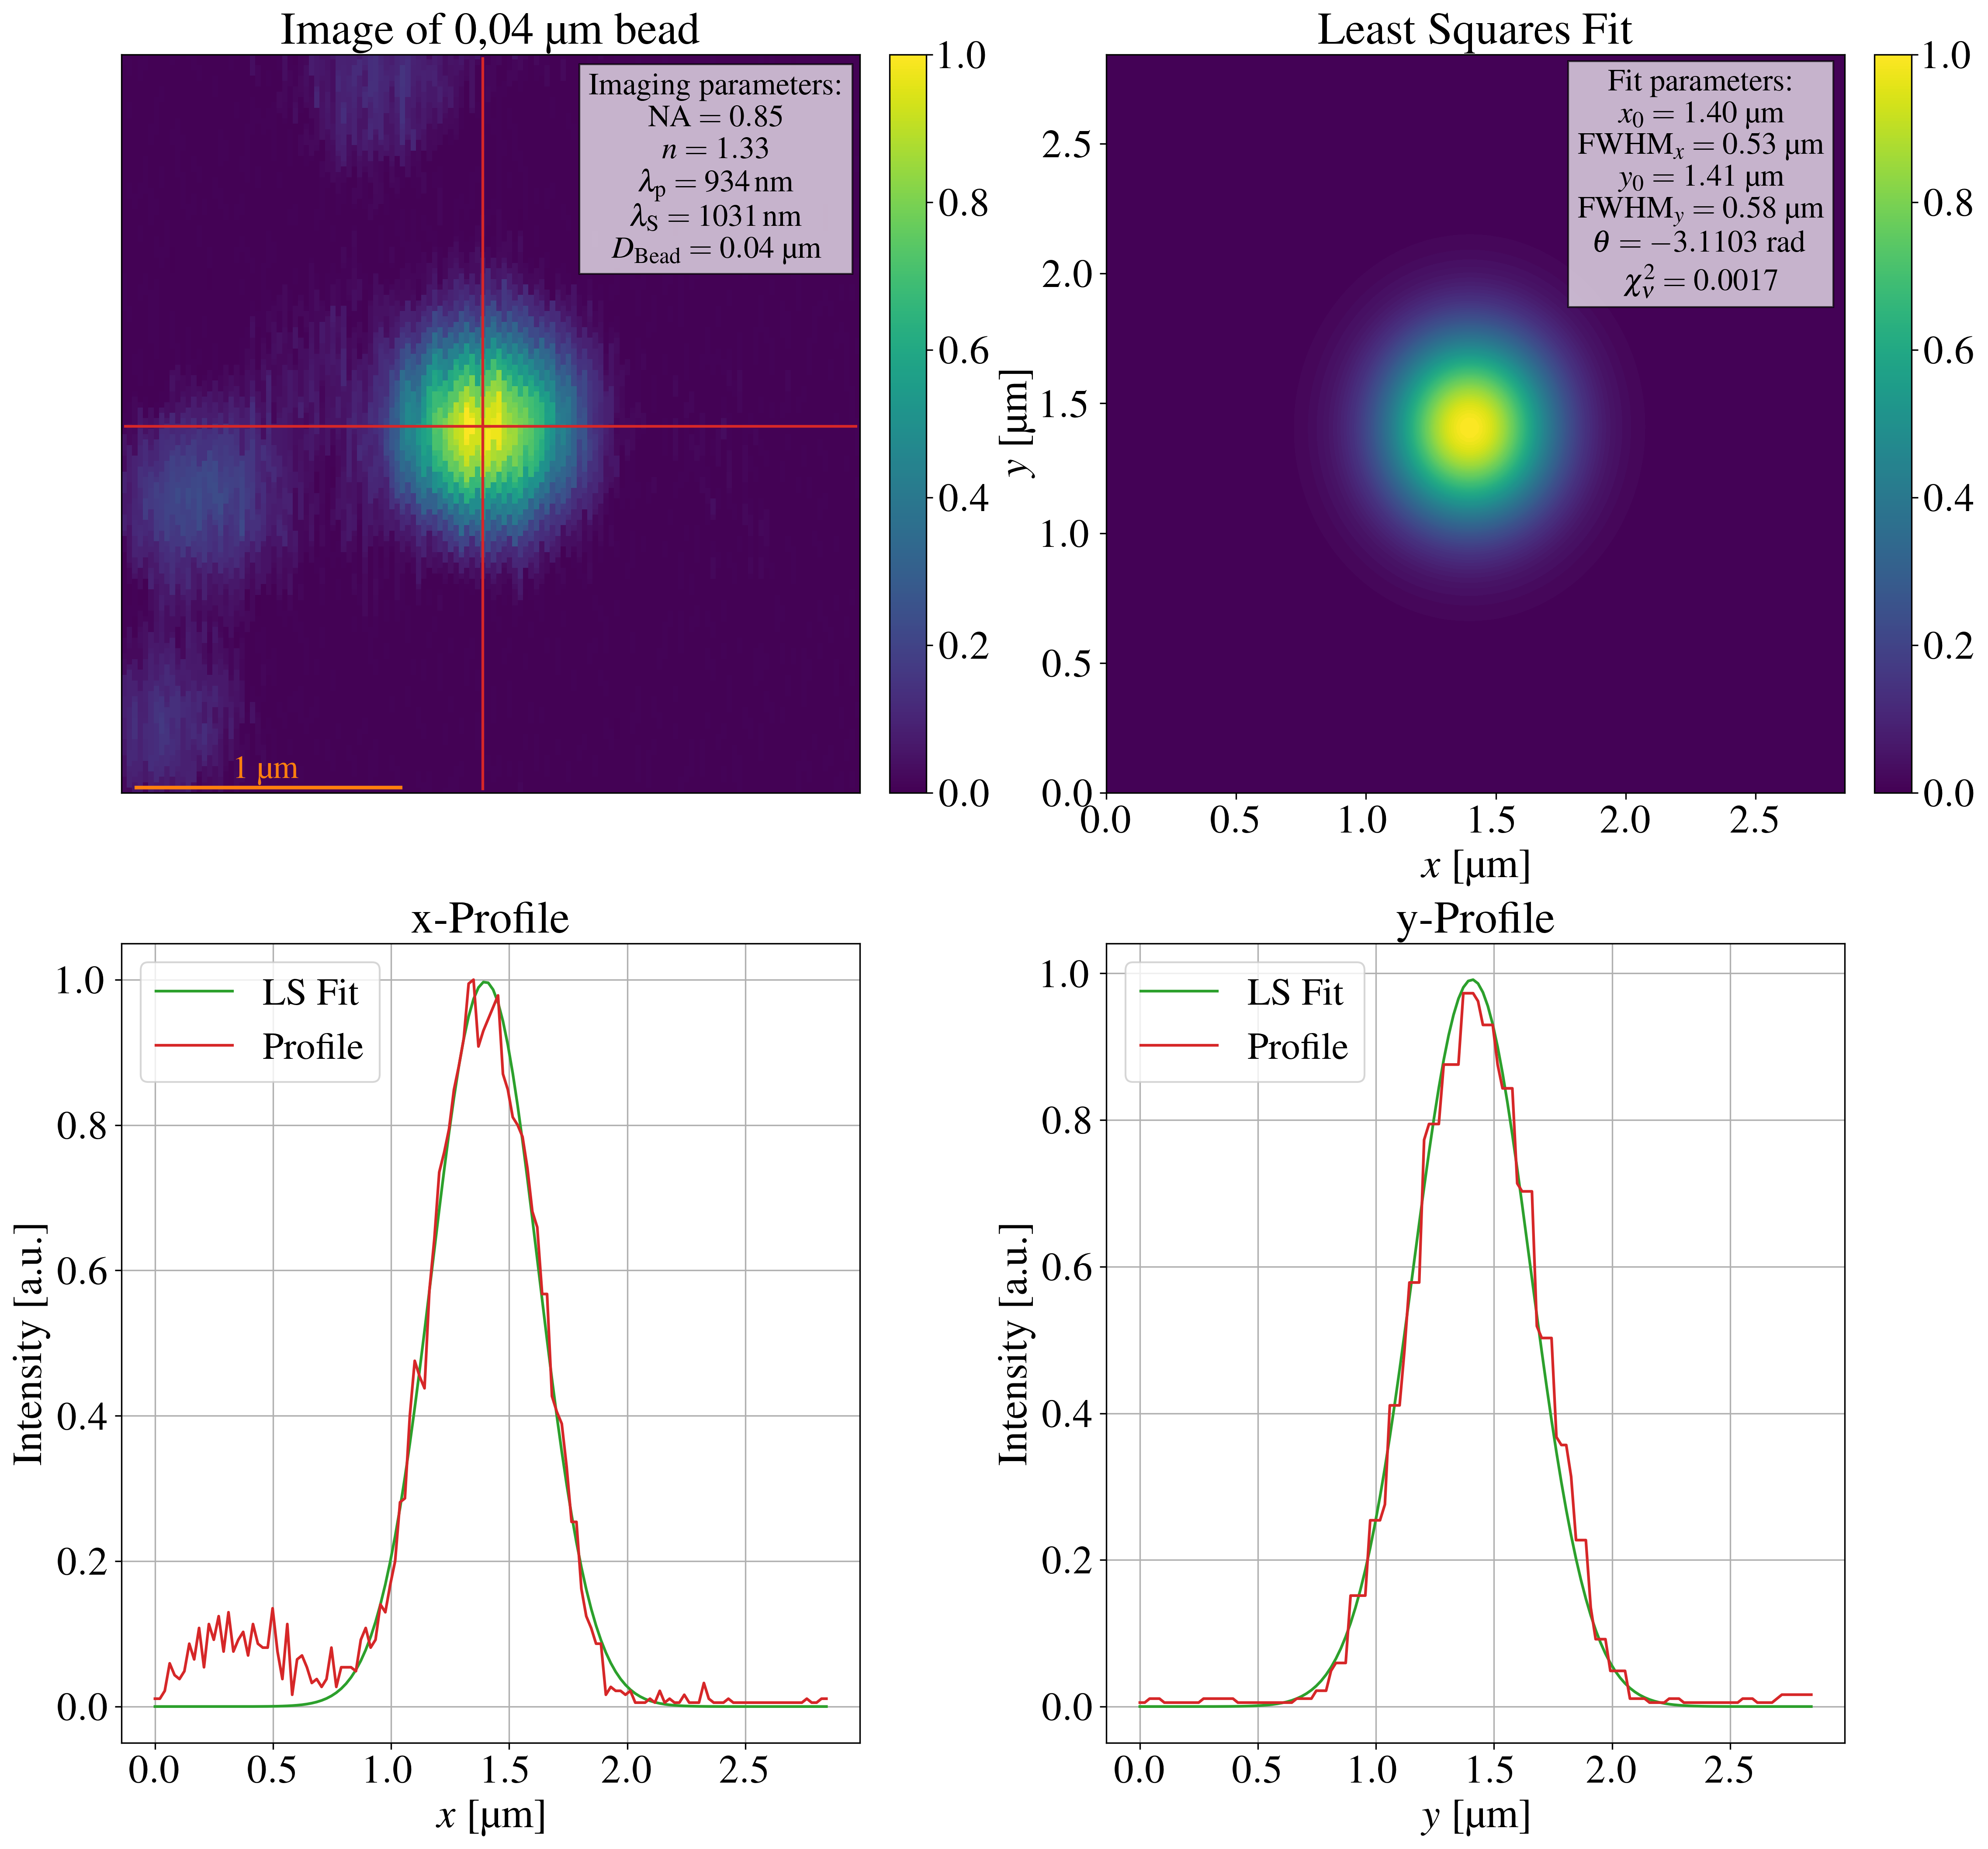

In [11]:
fig, axs =plt.subplot_mosaic([[0, 1],
                              [2, 3]], layout='constrained',figsize=(15,14))
#fig.suptitle('Comparison of the measured PSF to the theoretical PSF')
contourf_levels = np.linspace(0, popt[4], 90)

ax=axs[0]
cmap=mpl.cm.viridis
ax.imshow(image_cropped, cmap=cmap,vmin=0,vmax=np.max(image_cropped),label='Measured',origin='lower')
ax.hlines(np.argwhere(np.abs(y_array-popt[2])<0.01),xmin=0, xmax=x_resolution-1, color='tab:red')
ax.vlines(np.argwhere(np.abs(x_array-popt[0])<0.01),ymin=0, ymax=y_resolution-1, color='tab:red')
ax.set_title(r'Image of 0,04 \textmu m bead')
cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=ax, orientation='vertical',fraction=0.05, pad=0.04)
#cbar.set_ticks([])
ax.set_yticks([])
ax.set_xticks([])
ax.set_aspect('equal')
boxcontent = '\n'.join((
    r'Imaging parameters:',
    r'$\mathrm{NA}=%.2f$' % (num_ap, ),
    r'$n=%.2f$' % (ref_index, ),
    r'$\lambda_{\mathrm{p}}=%.0f\,\mathrm{nm}$' % (wl_p*10**3, ),
    r'$\lambda_{\mathrm{S}}=%.0f\,\mathrm{nm}$' % (wl_S*10**3, ),
    r'$D_{\mathrm{Bead}} = %.2f$ \textmu m' % (bead_diameter) ))
boxprops=dict(boxstyle='square', facecolor='white', alpha=0.7)
ax.text(0.805, 0.845, boxcontent, transform=ax.transAxes, fontsize=17,
        verticalalignment='center',horizontalalignment='center', bbox=boxprops) 
#scalebar
ax.hlines(0.5, xmin=2, xmax=52, color='tab:orange', linewidth=2)	
ax.text(0.2, 0.03, r'$%.0f$ \textmu m'%(49*pixel_pitch), transform=ax.transAxes, fontsize=18,
        verticalalignment='center', horizontalalignment='center', color='tab:orange') 
ax=axs[1]
cf=ax.contourf(x_array,y_array,fitted_gaussian.T,vmax=popt[4], levels=contourf_levels, cmap=cmap, label='Least Squares Fit',antialiasing=True)
cf.set_edgecolor("face")
ax.set_title(r'Least Squares Fit')
cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=ax, orientation='vertical',fraction=0.05, pad=0.04)
#cbar.set_ticks([])
ax.set_aspect('equal')
ax.set_ylabel(r'$y$ [\textmu m]')
ax.set_xlabel(r'$x$ [\textmu m]')
boxcontent = '\n'.join((
    r'Fit parameters:',
    r'$x_0=%.2f$ \textmu m' % (popt[0], ),
    r'$\mathrm{FWHM}_x=%.2f$ \textmu m' % (2.355*popt[1], ),
    r'$y_0=%.2f$ \textmu m' % (popt[2], ),
    r'$\mathrm{FWHM}_y=%.2f $ \textmu m' % (2.355*popt[3], ),
    r'$\theta=%.4f$ rad' % (popt[5], ),
    r'$\chi_{\nu}^{2}=%.4f$' % (reduced_chi_squared)
    ))
boxprops=dict(boxstyle='square', facecolor='white', alpha=0.7)
ax.text(0.805, 0.825, boxcontent, transform=ax.transAxes, fontsize=17,
        verticalalignment='center', horizontalalignment='center', bbox=boxprops) 
ax=axs[2]
ax.set_title(r'x-Profile')
ax.plot(x_array, fitted_gaussian[:,int(y_resolution/2)],color='tab:green',label='LS Fit')
ax.plot(x_array, (image_cropped/np.max(image_cropped))[int(y_resolution/2),:],color='tab:red',label='Profile')
ax.legend(loc='upper left')
ax.set_xlabel(r'$x$ [\textmu m]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_xticks([0,0.5,1.0,1.5,2.0,2.5])
#ax.set_title(r'Comparison of the lateral extent of the measured PSF to the theoretical PSF')
#ax.set_xlim(0,2.8)
#ax.ylim(0.0,1.1)
ax.grid(visible=True)
#fig.savefig('PSFs_zplane_integrated.svg',bbox_inches='tight')
ax=axs[3]
ax.set_title(r'y-Profile')
ax.plot(y_array, fitted_gaussian[int(x_resolution/2),:],color='tab:green',label='LS Fit')
ax.plot(y_array, (image_cropped/np.max(image_cropped))[:,int(x_resolution/2)],color='tab:red',label='Profile')
ax.legend(loc='upper left')
ax.set_xlabel(r'$y$ [\textmu m]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_xticks([0,0.5,1.0,1.5,2.0,2.5])
ax.grid(visible=True)

#fig.savefig(r'C:\Users\dan20\OneDrive - Johann Wolfgang Goethe Universität\Module\Masterarbeit\Tex Dokument\Abbildungen\PSF_mosaic.pdf', bbox_inches='tight')
fig.savefig(r'C:\Users\dan20\OneDrive - Johann Wolfgang Goethe Universität\Module\Masterarbeit\Group_Seminar\Figures\PSF_mosaic.png',dpi=400, bbox_inches='tight')
fig.show()

C:\Users\dan20\AppData\Local\Temp\ipykernel_18744\72192834.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(x_array,y_array,fitted_gaussian.T,vmax=popt[4], levels=contourf_levels, cmap=cmap, label='Least Squares Fit')
C:\Users\dan20\AppData\Local\Temp\ipykernel_18744\72192834.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


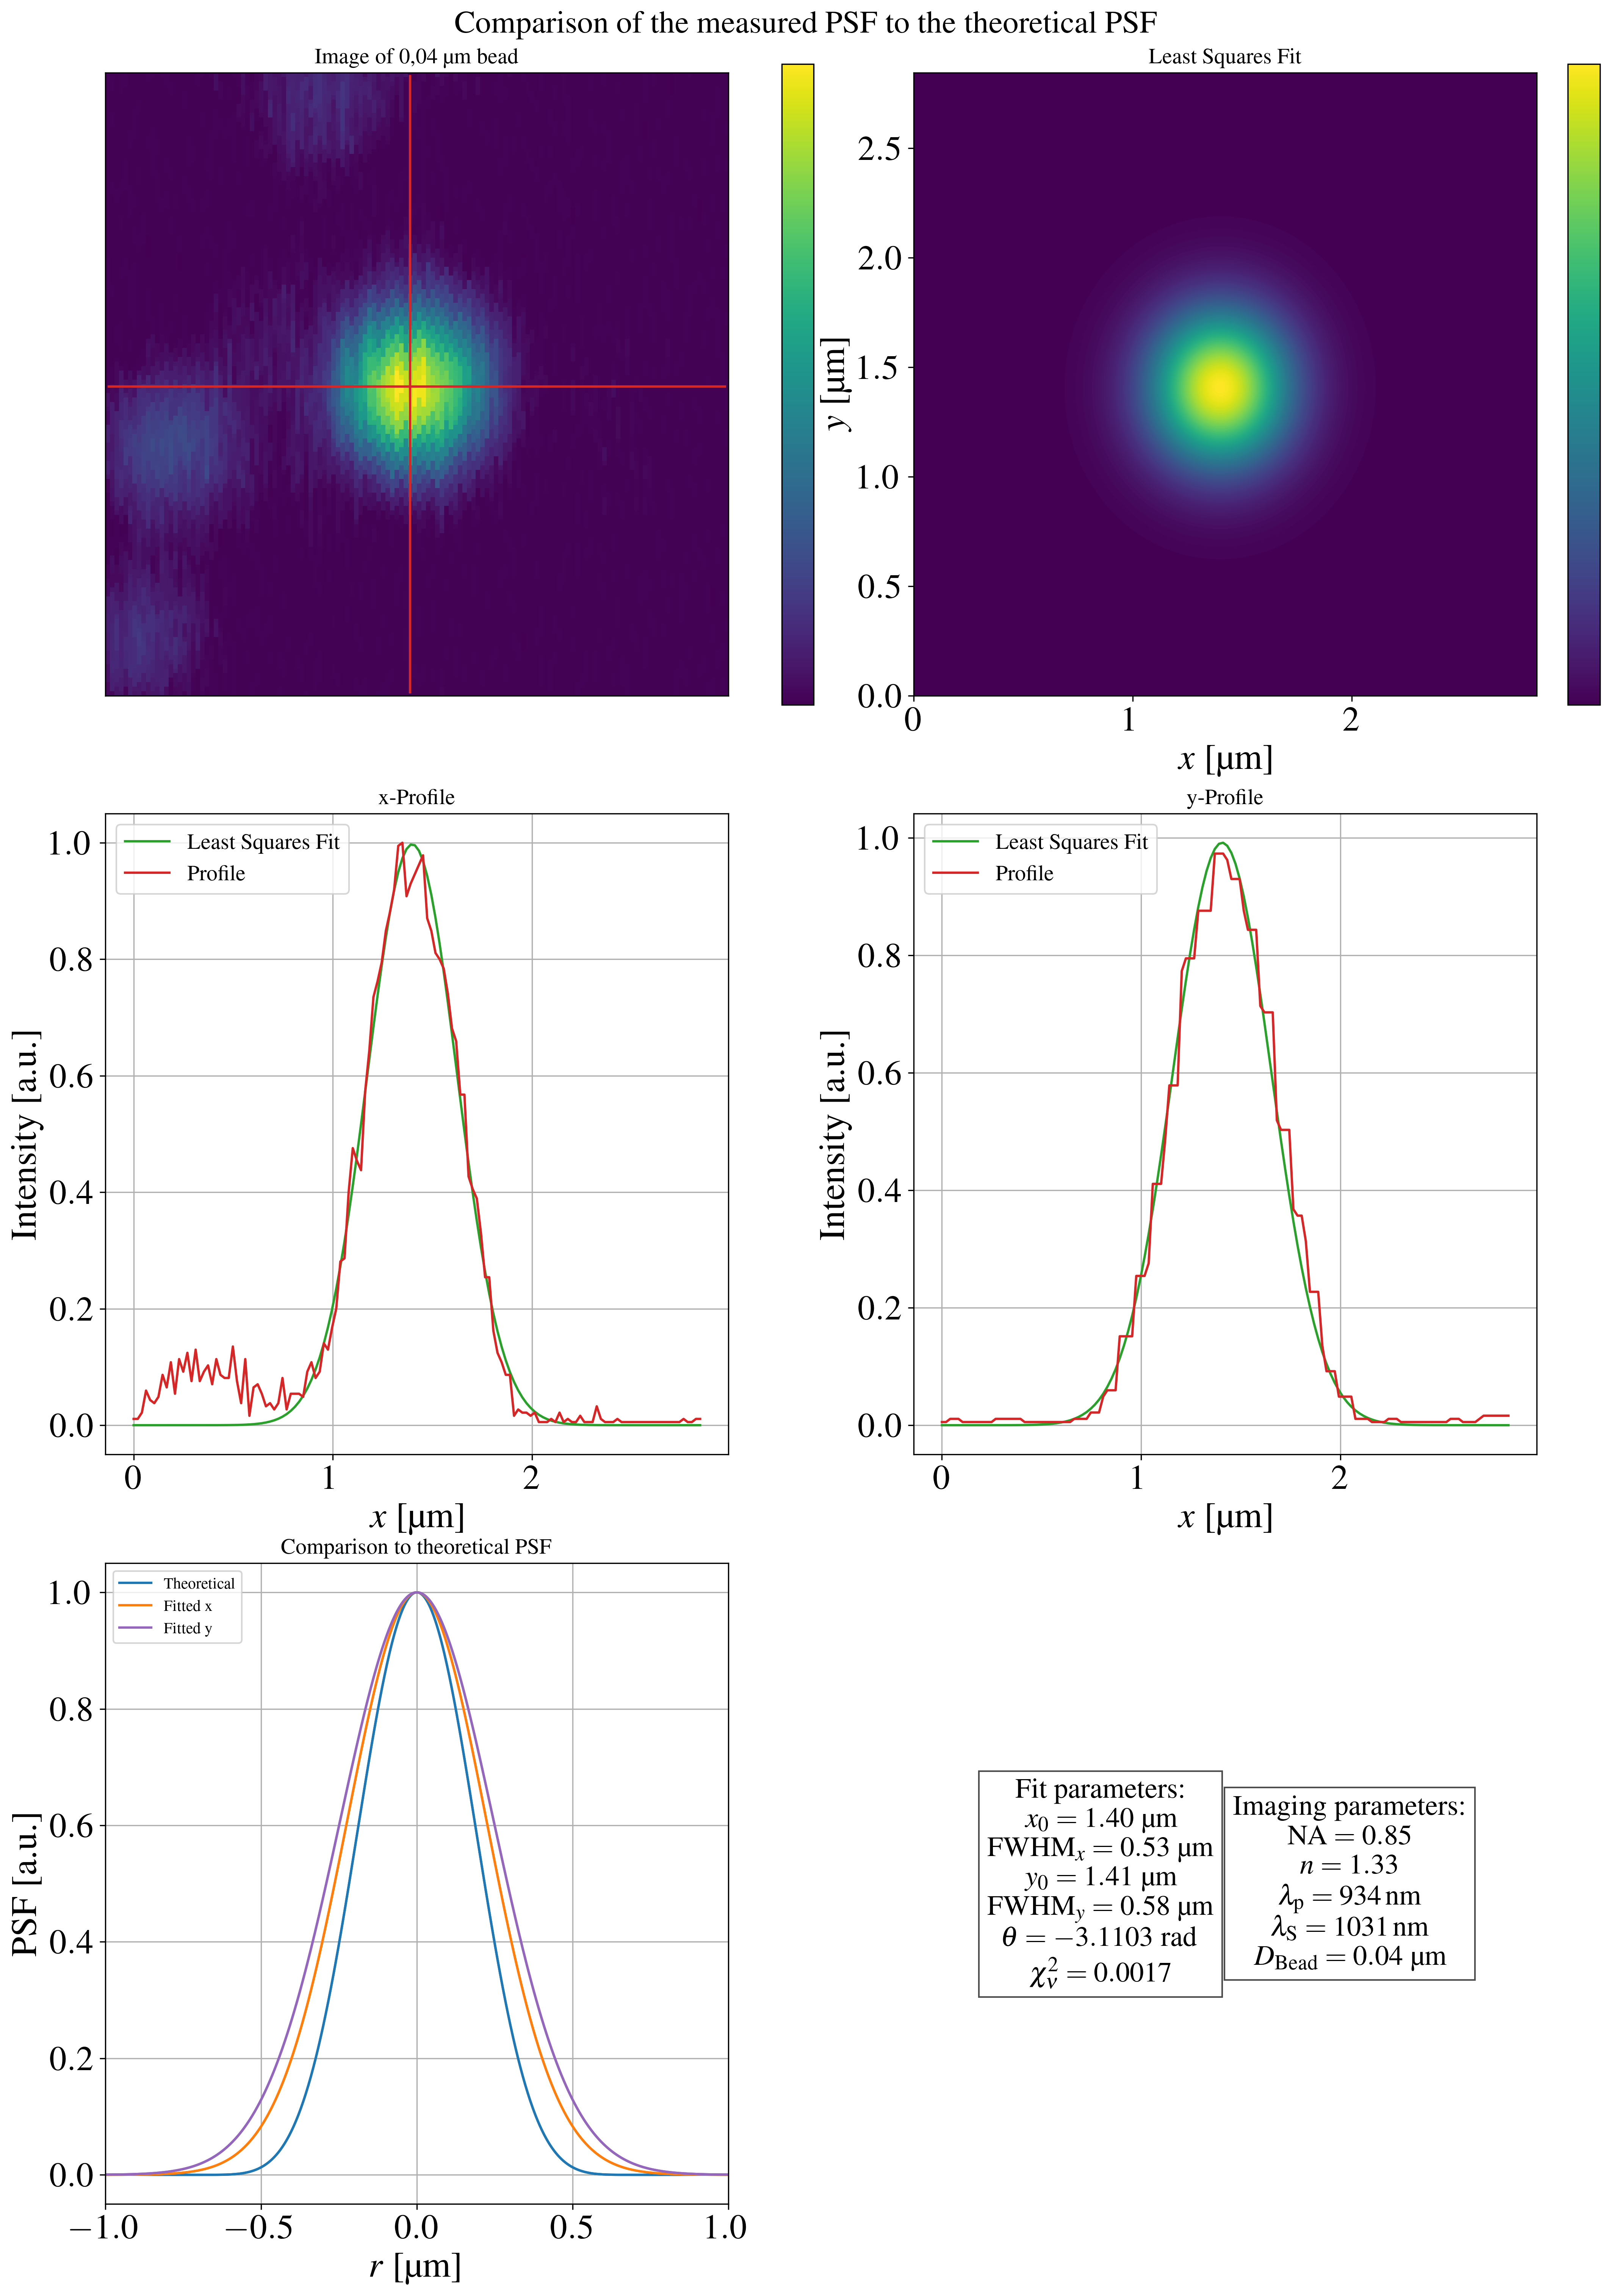

In [12]:
fig, axs =plt.subplot_mosaic([[0, 1],
                              [2, 3],[4, 5]], layout='constrained',figsize=(14,20))
fig.suptitle('Comparison of the measured PSF to the theoretical PSF', fontsize=20)
contourf_levels = np.linspace(0, popt[4], 150)

ax=axs[0]
cmap=mpl.cm.viridis
ax.imshow(image_cropped, cmap=cmap,vmin=0,vmax=np.max(image_cropped),label='Measured',origin='lower')
ax.hlines(np.argwhere(np.abs(y_array-popt[2])<0.01),xmin=0, xmax=x_resolution-1, color='tab:red')
ax.vlines(np.argwhere(np.abs(x_array-popt[0])<0.01),ymin=0, ymax=y_resolution-1, color='tab:red')
ax.set_title(r'Image of 0,04 \textmu m bead',fontsize=14)
cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=ax, orientation='vertical',)
cbar.set_ticks([])
ax.set_yticks([])
ax.set_xticks([])
ax.set_aspect('equal')

ax=axs[1]
ax.contourf(x_array,y_array,fitted_gaussian.T,vmax=popt[4], levels=contourf_levels, cmap=cmap, label='Least Squares Fit')
ax.set_title(r'Least Squares Fit',fontsize=14)
cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=ax, orientation='vertical',)
cbar.set_ticks([])
ax.set_aspect('equal')
ax.set_ylabel(r'$y$ [\textmu m]')
ax.set_xlabel(r'$x$ [\textmu m]')

ax=axs[2]
ax.set_title(r'x-Profile',fontsize=14)
ax.plot(x_array, fitted_gaussian[:,int(y_resolution/2)],color='tab:green',label='Least Squares Fit')
ax.plot(x_array, (image_cropped/np.max(image_cropped))[int(y_resolution/2),:],color='tab:red',label='Profile')
ax.legend(loc='upper left',fontsize=14)
ax.set_xlabel(r'$x$ [\textmu m]')
ax.set_ylabel(r'Intensity [a.u.]')
#ax.set_title(r'Comparison of the lateral extent of the measured PSF to the theoretical PSF')
#ax.xlim(-2,2)
#ax.ylim(0.0,1.1)
ax.grid(visible=True)
#fig.savefig('PSFs_zplane_integrated.svg',bbox_inches='tight')
ax=axs[3]
ax.set_title(r'y-Profile',fontsize=14)
ax.plot(y_array, fitted_gaussian[int(x_resolution/2),:],color='tab:green',label='Least Squares Fit')
ax.plot(y_array, (image_cropped/np.max(image_cropped))[:,int(x_resolution/2)],color='tab:red',label='Profile')
ax.legend(loc='upper left',fontsize=14)
ax.set_xlabel(r'$x$ [\textmu m]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.grid(visible=True)

ax=axs[4]
ax.plot(r_array,PSF_srs[:,int(z_num/2)],color='tab:blue',label='Theoretical')
ax.plot(-r_array,PSF_srs[:,int(z_num/2)],color='tab:blue')
ax.plot(r_array, gaussian_2d_vec(r_array,np.array([0]),*popt_zero),color='tab:orange',label='Fitted x')
ax.plot(-r_array, gaussian_2d_vec(-r_array,np.array([0]),*popt_zero),color='tab:orange')
ax.plot(r_array, gaussian_2d_vec(np.array([0]),r_array,*popt_zero)[0,:],color='tab:purple',label='Fitted y')
ax.plot(-r_array, gaussian_2d_vec(np.array([0]),-r_array,*popt_zero)[0,:],color='tab:purple')

ax.legend(loc='upper left',fontsize=10)
ax.set_xlabel(r'$r$ [\textmu m]')
ax.set_ylabel(r'PSF [a.u.]')
ax.set_title(r'Comparison to theoretical PSF',fontsize=14)
ax.set_xlim(-1,1)
ax.grid(visible=True)
ax=axs[5]
ax.axis('off')
boxcontent = '\n'.join((
    r'Imaging parameters:',
    r'$\mathrm{NA}=%.2f$' % (num_ap, ),
    r'$n=%.2f$' % (ref_index, ),
    r'$\lambda_{\mathrm{p}}=%.0f\,\mathrm{nm}$' % (wl_p*10**3, ),
    r'$\lambda_{\mathrm{S}}=%.0f\,\mathrm{nm}$' % (wl_S*10**3, ),
    r'$D_{\mathrm{Bead}} = %.2f$ \textmu m' % (bead_diameter) ))
boxprops=dict(boxstyle='square', facecolor='white', alpha=0.7)
ax.text(0.7, 0.5, boxcontent, transform=ax.transAxes, fontsize=18,
        verticalalignment='center',horizontalalignment='center', bbox=boxprops) 
boxcontent = '\n'.join((
    r'Fit parameters:',
    r'$x_0=%.2f$ \textmu m' % (popt[0], ),
    r'$\mathrm{FWHM}_x=%.2f$ \textmu m' % (2.355*popt[1], ),
    r'$y_0=%.2f$ \textmu m' % (popt[2], ),
    r'$\mathrm{FWHM}_y=%.2f $ \textmu m' % (2.355*popt[3], ),
    r'$\theta=%.4f$ rad' % (popt[5], ),
    r'$\chi_{\nu}^{2}=%.4f$' % (reduced_chi_squared)
    ))
boxprops=dict(boxstyle='square', facecolor='white', alpha=0.7)
ax.text(0.3, 0.5, boxcontent, transform=ax.transAxes, fontsize=18,
        verticalalignment='center',horizontalalignment='center', bbox=boxprops) 
#fig.savefig('PSF_mosaic.pdf', bbox_inches='tight')
fig.show()

In [13]:
bead_array = np.where(np.abs(r_array) <= 0.04, 1, 0)
print(bead_array)
theoretical_bead_image=sp.signal.fftconvolve(PSF_srs[:,int(z_num/2)], bead_array , mode='same')
theoretical_bead_image=theoretical_bead_image/np.max(theoretical_bead_image)

[0 0 0 ... 0 0 0]


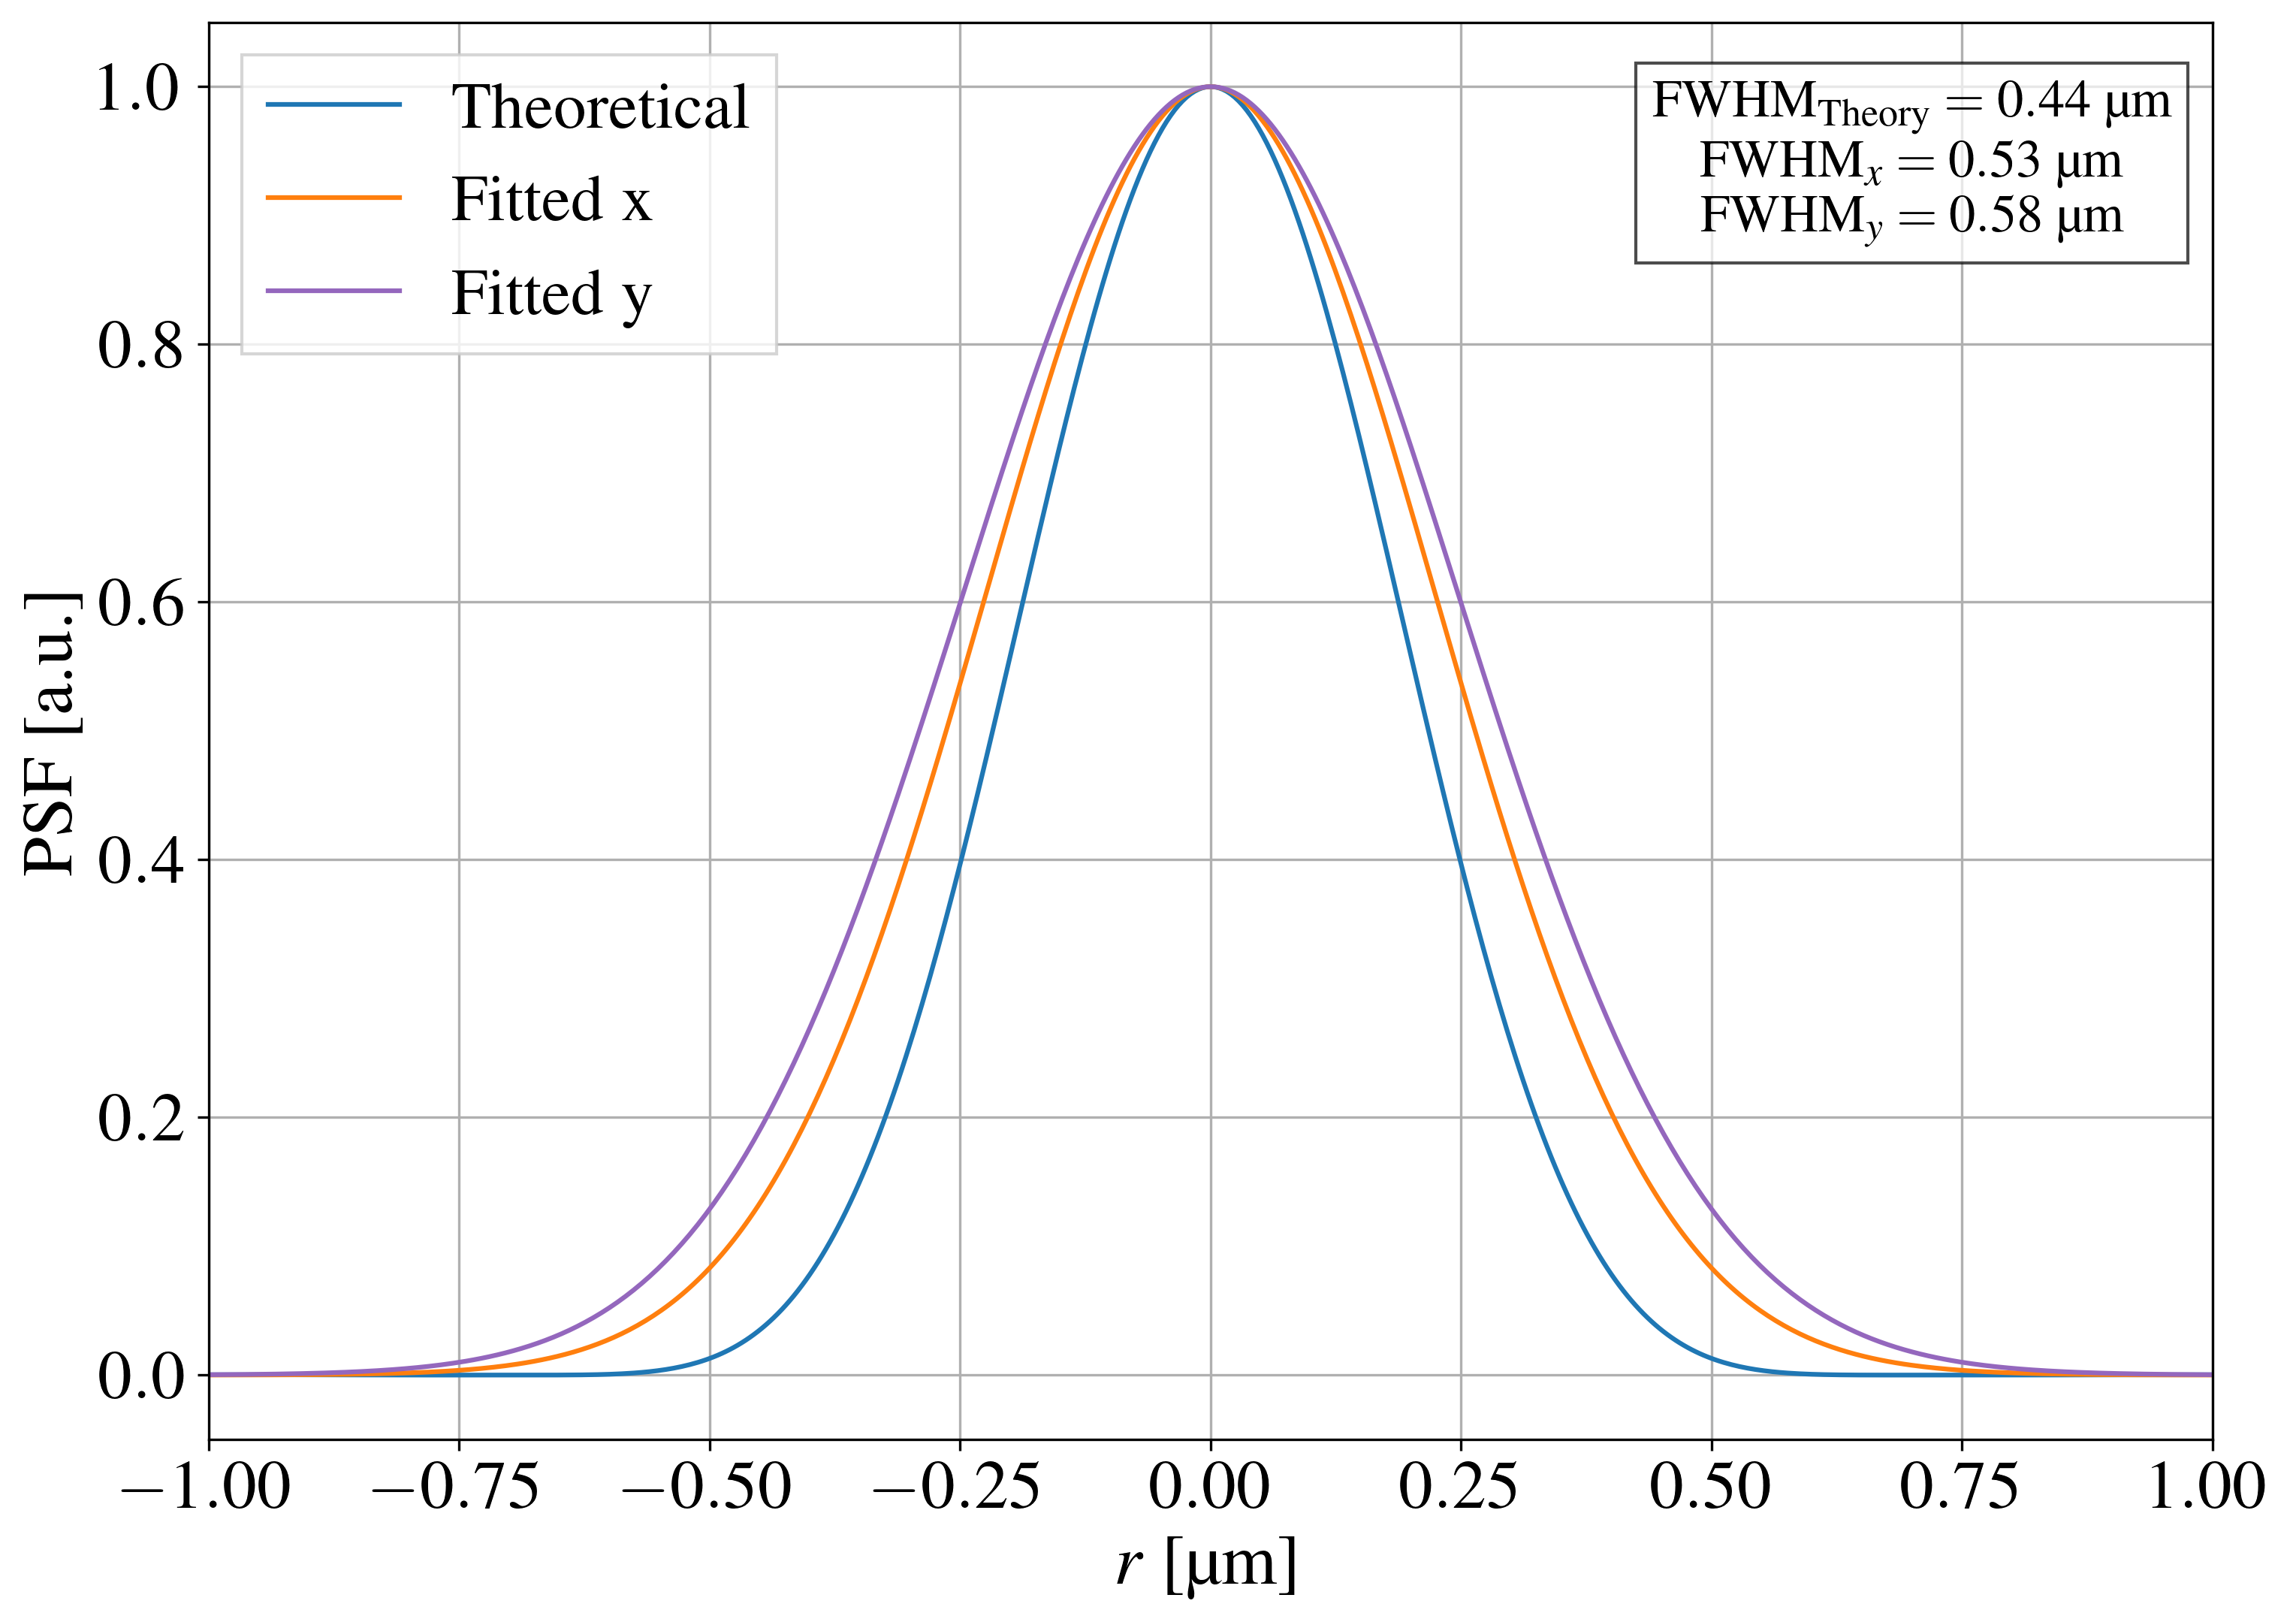

In [ ]:
fig, ax =plt.subplots(figsize=(10,7),layout='constrained', frameon=True)

 

    

plt.plot(r_array, PSF_srs[:,int(z_num/2)], color='tab:blue',label='Theoretical')
#plt.plot(-r_array,PSF_srs[:,int(z_num/2)],color='tab:blue')
plt.plot(r_array, gaussian_2d_vec(r_array,np.array([0]),*popt_zero),color='tab:orange',label='Fitted x')
#plt.plot(-r_array, gaussian_2d_vec(-r_array,np.array([0]),*popt_zero),color='tab:orange')
plt.plot(r_array, gaussian_2d_vec(np.array([0]),r_array,*popt_zero)[0,:],color='tab:purple',label='Fitted y')
#plt.plot(-r_array, gaussian_2d_vec(np.array([0]),-r_array,*popt_zero)[0,:],color='tab:purple')
plt.legend(loc='upper left', fancybox=False)
plt.xlabel(r'$r$ [\textmu m]')
plt.ylabel(r'PSF [a.u.]')
#plt.title(r'Comparison of the lateral extent of the measured PSF to the theoretical PSF')
plt.xlim(-1,1)
plt.grid(visible=True)


FWHM_axial_theory = 2*r_array[np.isclose(theoretical_bead_image, 0.5, 0.01)][-1]
boxcontent = '\n'.join((
    r'$\mathrm{FWHM_{Theory}}=%.2f$ \textmu m' % (FWHM_axial_theory, ),
    r'$\mathrm{FWHM}_x=%.2f$ \textmu m' % (2.355*popt[1], ),
    r'$\mathrm{FWHM}_y=%.2f $ \textmu m' % (2.355*popt[3], ),
    ))
boxprops=dict(boxstyle='square', facecolor='white', alpha=0.7)
plt.text(0.85, 0.9, boxcontent, transform=ax.transAxes, fontsize=17,
        verticalalignment='center',horizontalalignment='center', bbox=boxprops)
plt.show()
#fig.savefig(r'C:\Users\dan20\OneDrive - Johann Wolfgang Goethe Universität\Module\Masterarbeit\Tex Dokument\Abbildungen\measured_vs_theory.pdf', bbox_inches='tight')
#fig.savefig(r'C:\Users\dan20\OneDrive - Johann Wolfgang Goethe Universität\Module\Masterarbeit\Group_Seminar\Figures\measured_vs_theory.png',dpi=400, bbox_inches='tight')

In [15]:
fig3d = go.Figure(data=go.Surface(x=x_array,y=y_array,z=image_cropped,contours={"z": {"show": True, "start": 0.0, "end": 0.2, "size": 0.005}}))
fig3d.update_layout(title='Measured Point Spread Function', autosize=True, xaxis_title="x", yaxis_title="y",scene_aspectratio=dict(x=1, y=1, z=1)
                  )
fig3d.show()

In [16]:
fig3d = go.Figure(data=go.Surface(x=x_array,y=y_array,z=gaussian_2d_vec(x_array,y_array,*popt)))
fig3d.update_layout(title='Fitted Point Spread Function', autosize=True, xaxis_title="x", yaxis_title="y",scene_aspectratio=dict(x=1, y=1, z=1))
fig3d.show()

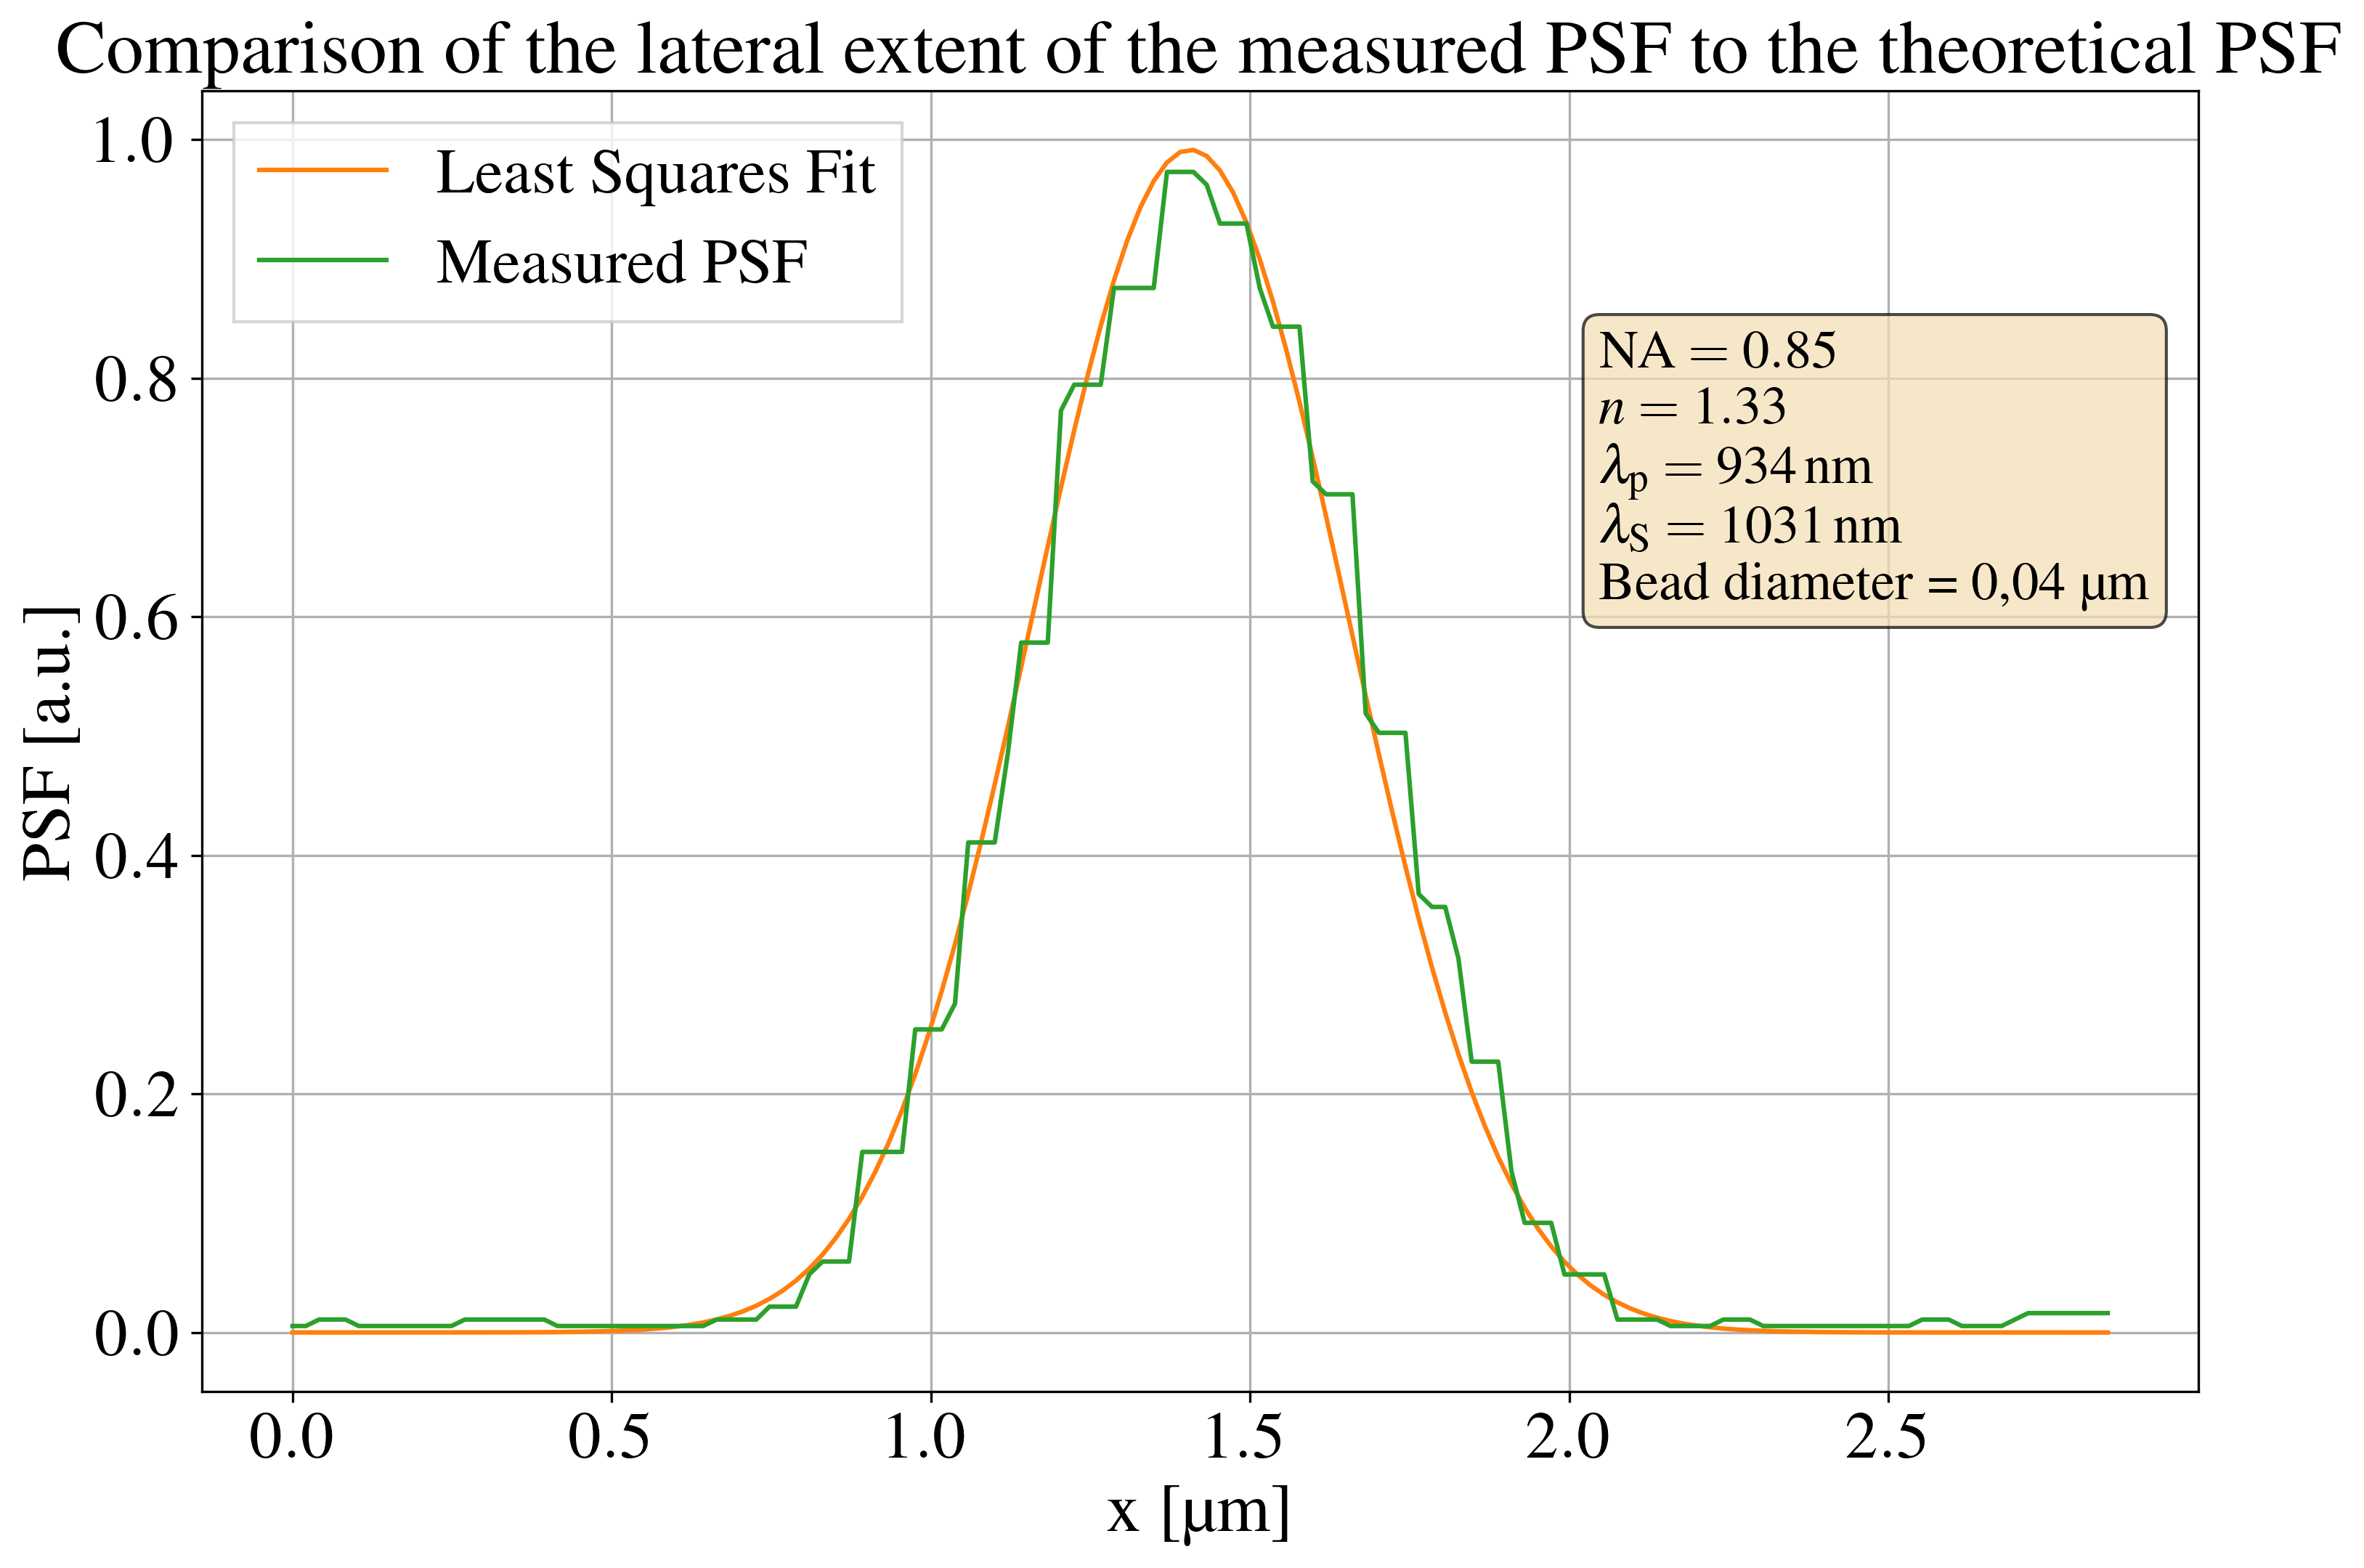

In [17]:
fig, ax =plt.subplots(figsize=(10,7),layout='constrained', frameon=True)
boxcontent = '\n'.join((
    r'$\mathrm{NA}=%.2f$' % (num_ap, ),
    r'$n=%.2f$' % (ref_index, ),
    r'$\lambda_{\mathrm{p}}=%.0f\,\mathrm{nm}$' % (wl_p*10**3, ),
    r'$\lambda_{\mathrm{S}}=%.0f\,\mathrm{nm}$' % (wl_S*10**3, ),
    r'Bead diameter = 0,04 \textmu m' ))
boxprops=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
plt.text(0.7, 0.6, boxcontent, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=boxprops)
plt.plot(y_array, gaussian_2d_vec(x_array,y_array,*popt)[int(x_resolution/2),:],color='tab:orange',label='Least Squares Fit')
plt.plot(y_array, (image_cropped/np.max(image_cropped))[:,int(x_resolution/2)],color='tab:green',label='Measured PSF')

plt.legend(loc='upper left', fancybox=False)
plt.xlabel(r'x [\textmu m]')
plt.ylabel(r'PSF [a.u.]')
plt.title(r'Comparison of the lateral extent of the measured PSF to the theoretical PSF')
#plt.xlim(-2,2)
#plt.ylim(0.0,1.1)
plt.grid(visible=True)
#fig.savefig('PSFs_zplane_integrated.svg',bbox_inches='tight')
#fig.savefig('measured_vs_theory.pdf',bbox_inches='tight')
plt.show()

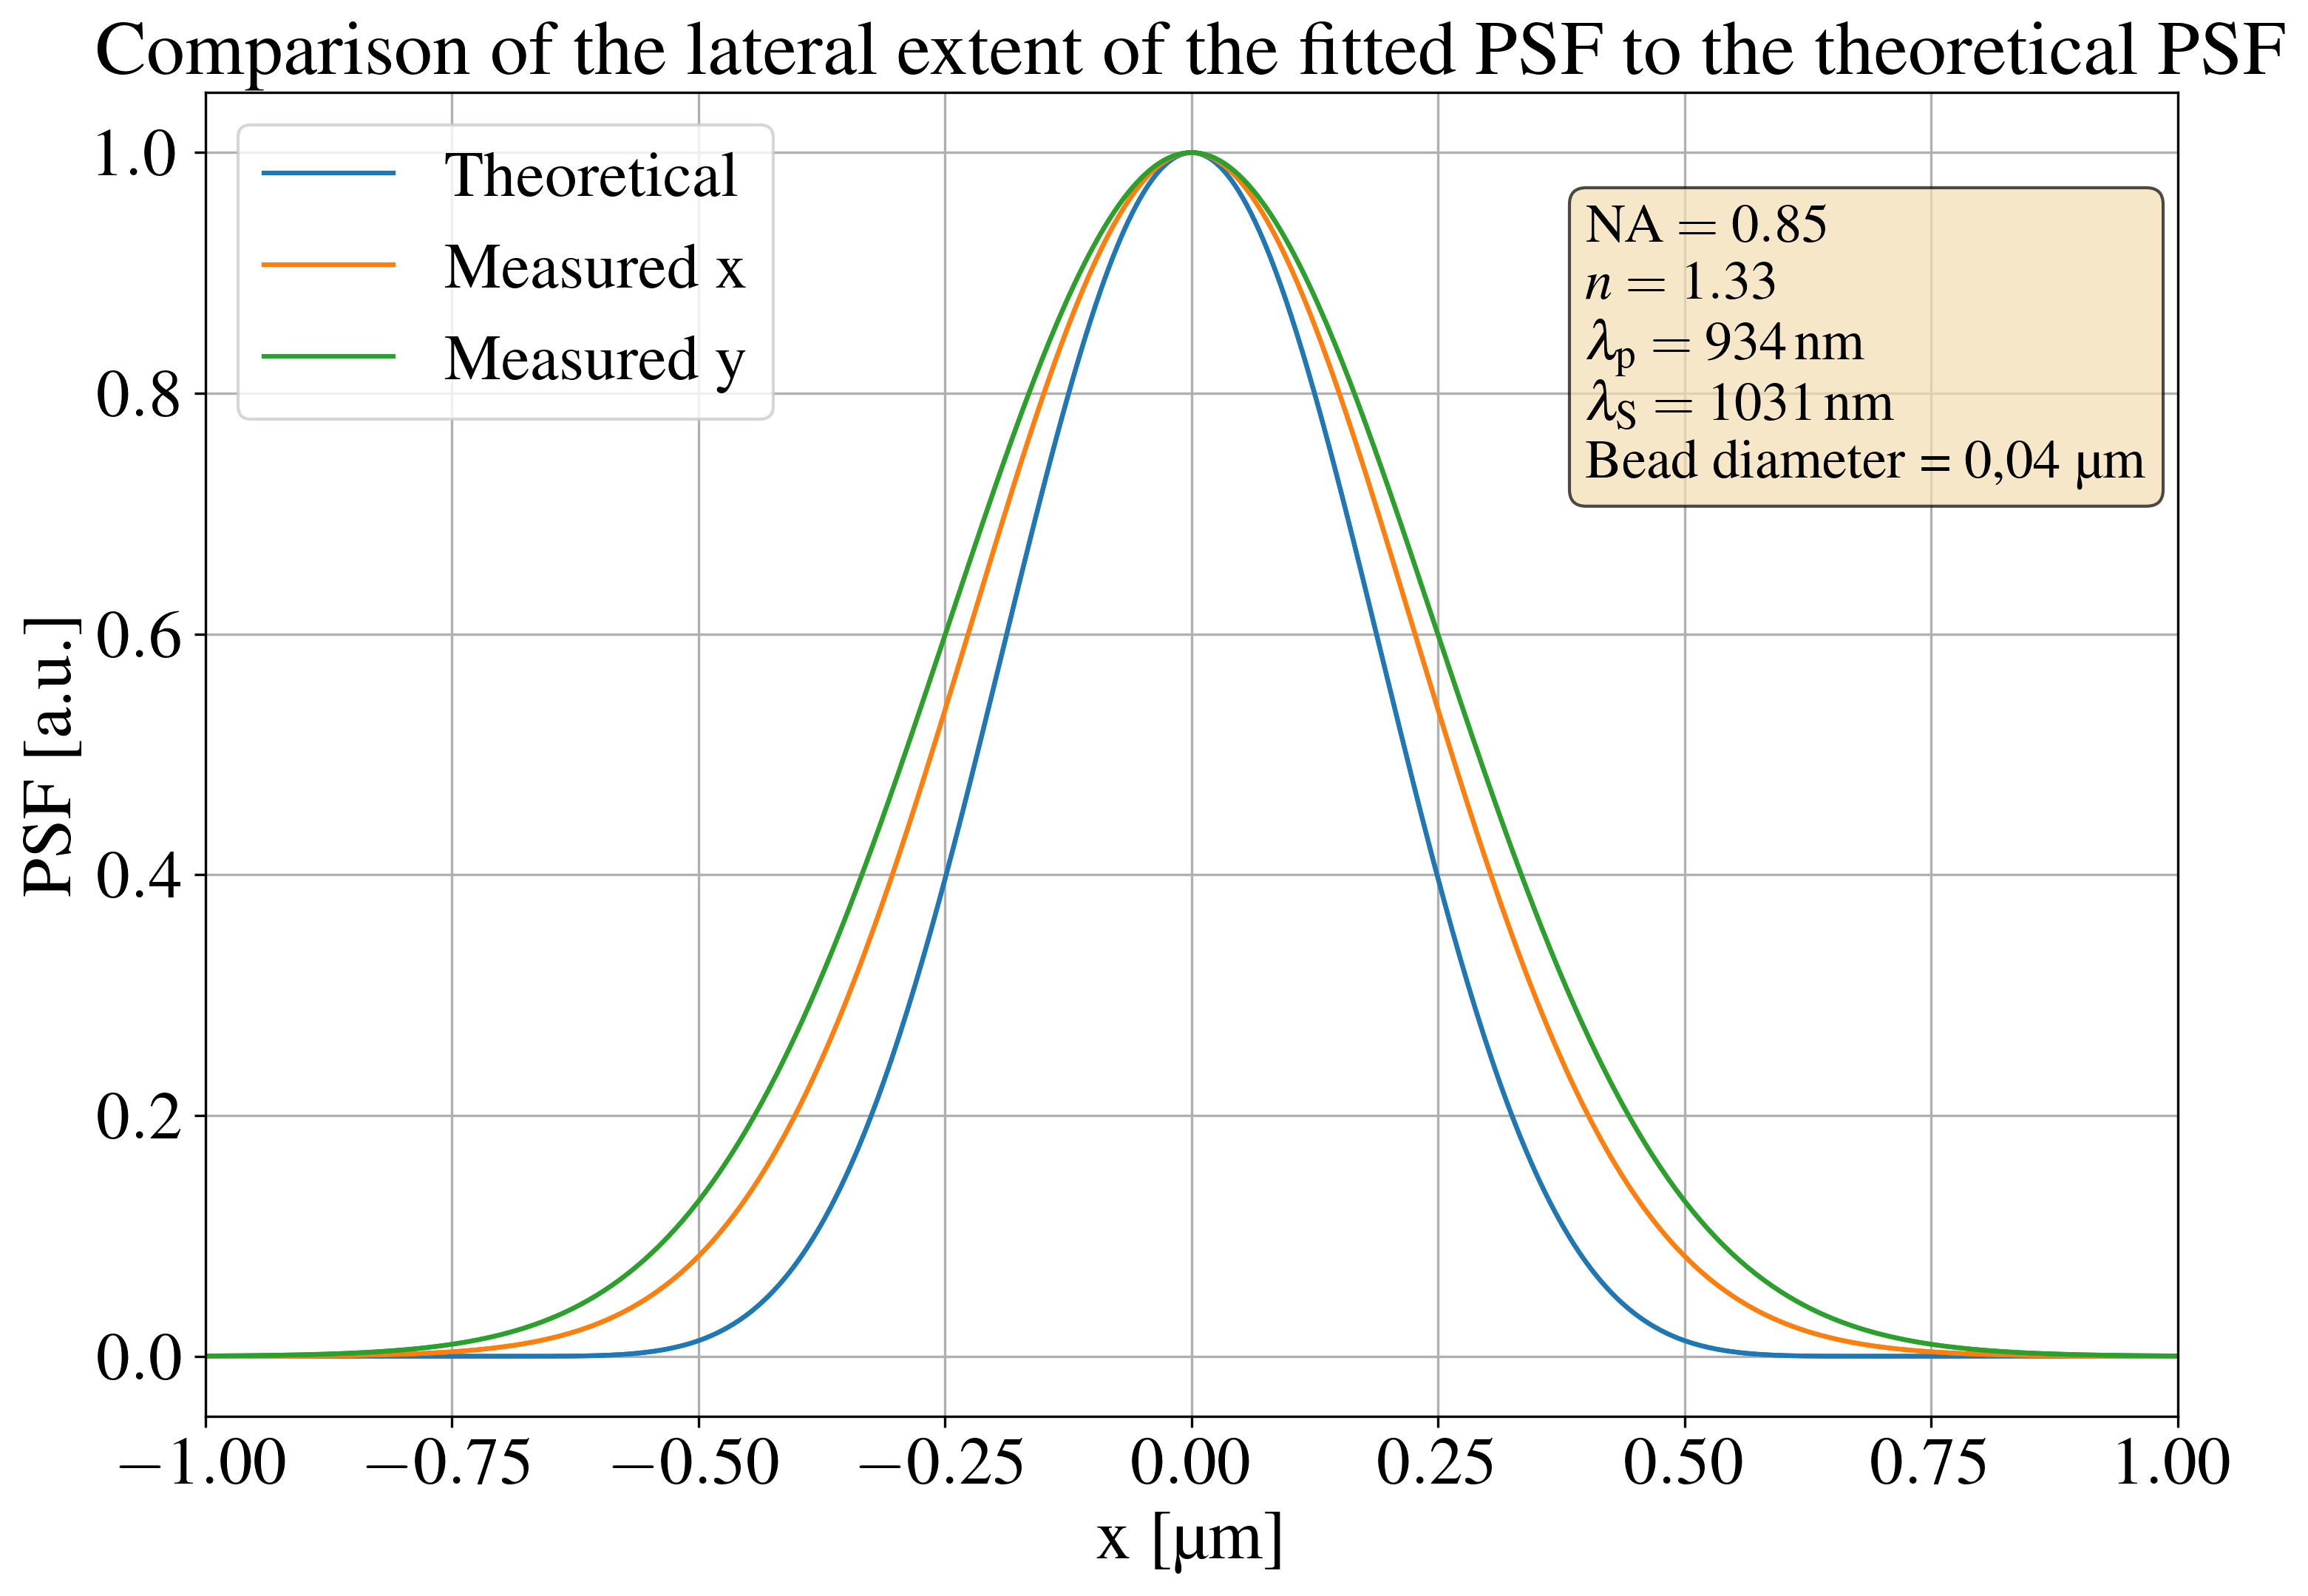

In [18]:

cmap_norm=mpl.colors.LogNorm(1e-3,1)
cmap=mpl.cm.viridis
contour_levels=np.geomspace(1e-4,1,num=11)
contourf_levels=np.geomspace(1e-3,1,num=31)
cmap=mpl.cm.viridis

fig, ax =plt.subplots(figsize=(10,7),layout='constrained', frameon=True)

boxcontent = '\n'.join((
    r'$\mathrm{NA}=%.2f$' % (num_ap, ),
    r'$n=%.2f$' % (ref_index, ),
    r'$\lambda_{\mathrm{p}}=%.0f\,\mathrm{nm}$' % (wl_p*10**3, ),
    r'$\lambda_{\mathrm{S}}=%.0f\,\mathrm{nm}$' % (wl_S*10**3, ),
    r'Bead diameter = 0,04 \textmu m'))
boxprops=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
plt.text(0.7, 0.7, boxcontent, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=boxprops)

plt.plot(r_array,PSF_srs[:,int(z_num/2)],color='tab:blue',label='Theoretical')
plt.plot(-r_array,PSF_srs[:,int(z_num/2)],color='tab:blue')

plt.plot(r_array, gaussian_2d_vec(r_array,np.array([0]),*popt_zero),color='tab:orange',label='Measured x')
plt.plot(-r_array, gaussian_2d_vec(-r_array,np.array([0]),*popt_zero),color='tab:orange')

plt.plot(r_array, gaussian_2d_vec(np.array([0]),r_array,*popt_zero)[0,:],color='tab:green',label='Measured y')
plt.plot(-r_array, gaussian_2d_vec(np.array([0]),-r_array,*popt_zero)[0,:],color='tab:green')
plt.legend(loc='upper left')
plt.xlabel(r'x [\textmu m]')
plt.ylabel(r'PSF [a.u.]')
plt.title('Comparison of the lateral extent of the fitted PSF to the theoretical PSF')
plt.xlim(-1,1)
#plt.ylim(0.0,1.1)
plt.grid(visible=True)
#fig.savefig('PSFs_zplane_integrated.svg',bbox_inches='tight')
fig.savefig('fitted_vs_theory.png',dpi=300,bbox_inches='tight')
plt.show()